## 1. Project Setup

### 1.1 Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight


import warnings
import absl.logging

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Suppress absl logs
absl.logging.set_verbosity(absl.logging.ERROR)

# Suppress specific UserWarnings from PyDataset
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

### 1.2 Explore Dataset

In [3]:
# Enable mixed precision training (if supported by hardware)
policy = Policy('mixed_float16')
set_global_policy(policy)

# Define the dataset path
dataset_path = '/kaggle/input/wikiart'

# Ensure the dataset directory exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path '{dataset_path}' does not exist.")

# Load the class information
class_df = pd.read_csv(os.path.join(dataset_path, 'classes.csv'))

# Select three art styles
selected_styles = ['Expressionism', 'Post_Impressionism', 'Romanticism']
class_df = class_df[class_df['genre'].isin(selected_styles)]


# Create a new class-to-index mapping
class_to_index = {style: i for i, style in enumerate(selected_styles)}
num_classes = len(class_to_index)

## 2. Data Preparation

### 2.1 Preprocess Images

In [4]:
small_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Brightness adjustment
    channel_shift_range=0.1,  # Channel shifting
    validation_split=0.2
)


train_data = small_data_gen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=list(class_to_index.keys()),
    subset='training',
    shuffle=True,
    seed=42
)

val_data = small_data_gen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=list(class_to_index.keys()),
    subset='validation',
    shuffle=False
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_data.classes), 
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Found 16165 images belonging to 3 classes.
Found 4040 images belonging to 3 classes.
Class weights: {0: 0.9998762912104905, 1: 1.044250645994832, 2: 0.9594610636277303}


## 3. Model Creation

### 3.1 Load Pre-trained DenseNet

In [5]:
# Load the pre-trained (DenseNet121) model without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True


# Add custom classification head with adjusted regularization parameters
x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Increased L2 regularization
x = Dropout(0.6)(x)  # Increased dropout rate
output = Dense(num_classes, activation='softmax')(x)  # Match output nodes to num_classes

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Fine-tuning requires a smaller LR
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

# Added LambdaCallback to print loss at the end of each epoch
print_loss = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch} - Loss: {logs['loss']}"))

## 4. Train the Model

### 4.1 Training

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights,  # Apply class weights to handle class imbalance
    callbacks=[early_stopping, model_checkpoint, reduce_lr, print_loss]
)

Epoch 1/20


I0000 00:00:1734373524.264083     635 service.cc:145] XLA service 0x7c3d34002340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734373524.264145     635 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734373669.613544     635 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


272/506 ━━━━━━━━━━━━━━━━━━━━ 3:44 961ms/step - accuracy: 0.4100 - loss: 2.2000

I0000 00:00:1734374074.953139     637 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_73', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_82', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_83', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_84', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_91', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_537', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_534', 12 bytes spill stores, 12 bytes s

506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4578 - loss: 1.9392Epoch 0 - Loss: 1.5409783124923706
506/506 ━━━━━━━━━━━━━━━━━━━━ 992s 2s/step - accuracy: 0.4580 - loss: 1.9385 - val_accuracy: 0.6245 - val_loss: 1.2597 - learning_rate: 1.0000e-05
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.6560 - loss: 1.1570Epoch 1 - Loss: 1.1133633852005005
506/506 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.6560 - loss: 1.1569 - val_accuracy: 0.6604 - val_loss: 1.1486 - learning_rate: 1.0000e-05
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6953 - loss: 1.0257Epoch 2 - Loss: 1.0053225755691528
506/506 ━━━━━━━━━━━━━━━━━━━━ 598s 1s/step - accuracy: 0.6953 - loss: 1.0256 - val_accuracy: 0.6703 - val_loss: 1.0844 - learning_rate: 1.0000e-05
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.7297 - loss: 0.9530Epoch 3 - Loss: 0.9378108382225037
506/506 ━━━━━━━━━━━━━━━━━━━━ 598s 1s/step - accuracy: 0.7297 - loss: 0.9529 - val_accura

## 5. Evaluate the Model

### 5.1 Accuracy and Loss

In [7]:
test_loss, test_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_accuracy}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 876ms/step - accuracy: 0.7037 - loss: 0.9559
Validation Loss: 0.9475850462913513
Validation Accuracy: 0.7081683278083801


### 5.2 Confusion Matrix

In [8]:
# Generate predictions
y_pred = np.argmax(model.predict(val_data), axis=1)
y_true = val_data.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

127/127 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step
Confusion Matrix:
 [[1006  242   99]
 [ 355  801  134]
 [ 196   96 1111]]


### 5.3 Classification Report

In [9]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

Classification Report:
                    precision    recall  f1-score   support

     Expressionism       0.65      0.75      0.69      1347
Post_Impressionism       0.70      0.62      0.66      1290
       Romanticism       0.83      0.79      0.81      1403

          accuracy                           0.72      4040
         macro avg       0.73      0.72      0.72      4040
      weighted avg       0.73      0.72      0.72      4040



### 5.5 ROC Curve

127/127 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step


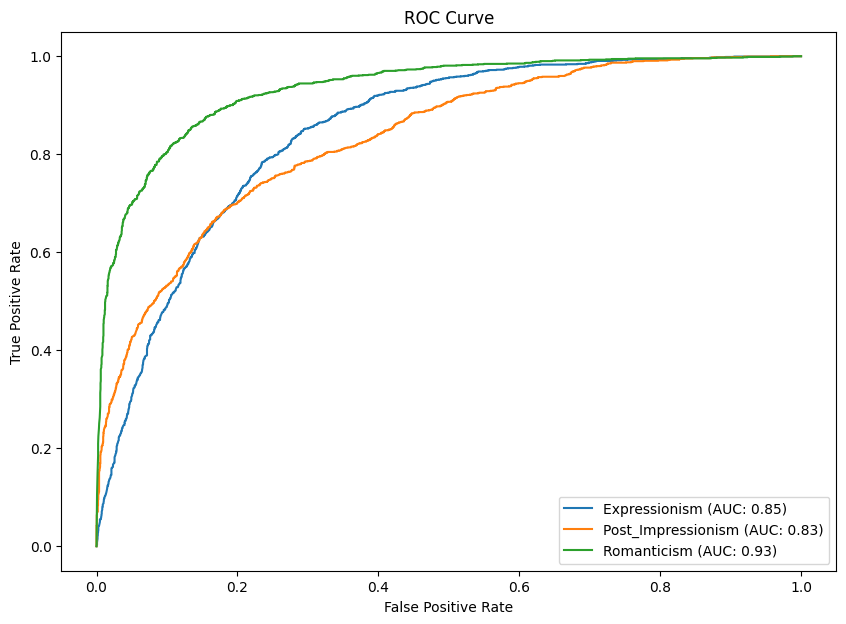

In [10]:
# Binarize the true labels (y_true) for multi-class classification
y_true_binarized = label_binarize(y_true, classes=range(num_classes))

# Predict probabilities for the validation set
y_pred_proba = model.predict(val_data)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{list(val_data.class_indices.keys())[i]} (AUC: {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## 6. Visualize Results

### 6.1 Training and Validation Accuracy

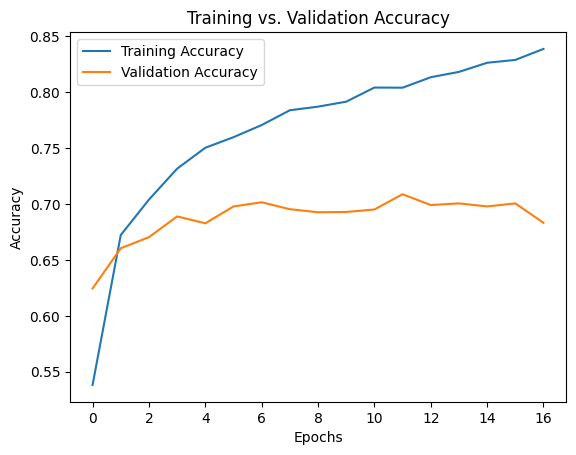

In [11]:
# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.show()

### 6.2 Confusion Matrix Heatmap

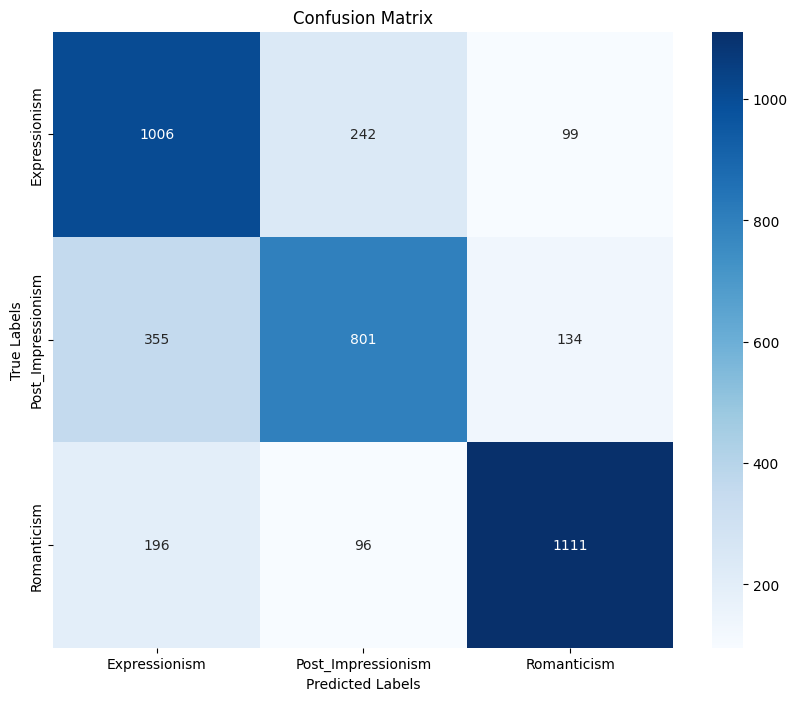

In [12]:
# Plot heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(val_data.class_indices.keys()), 
            yticklabels=list(val_data.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()